# Notebook #5: Series temporales: predicción a futuro del parque vehicular

In [47]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
from prophet import Prophet

# Importar las clases
# -----------------------------------------------------------------------
import sys
sys.path.append('../..')
from src import soporte_temporales as st
from src import soporte_sarima as ss
from src import soporte_funciones_BBDD as sfbd
from src import soporte_variables_vehiculos as svv

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA



# Visualizar las métricas de error en y_test
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuraciones
# -----------------------------------------------------------------------
pd.options.display.float_format = '{:.0f}'.format
from itertools import product

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Modelo ARIMA

In [48]:
df_autos_historicos = sfbd.dbeaver_fetch(sfbd.dbeaver_conexion("proyecto_final"),svv.query_autos_historico)

In [49]:
df_autos_historicos.head()

,anio,total
0,1998,936083
1,1999,1090833
2,2000,1294998
3,2001,1436165
4,2002,1611023


In [50]:
df_autos_historicos.columns = ['FECHA', 'Vehículos']
df_autos_historicos['FECHA'] = pd.to_datetime(df_autos_historicos['FECHA'].astype(str) + '-12-31')

In [51]:
df_autos_historicos.head()

,FECHA,Vehículos
0,1998-12-31,936083
1,1999-12-31,1090833
2,2000-12-31,1294998
3,2001-12-31,1436165
4,2002-12-31,1611023


In [52]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_autos_historicos, temporal_column="FECHA", value_column="Vehículos")

analisis_st.exploracion_datos()

El número de filas es 27 y el número de columnas es 1

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Vehículos,27,3118597,1526266,936083,1823660,2917573,4224111,6160988


In [53]:
analisis_st.comprobar_serie_continua(freq='A')

La serie temporal es continua para la frecuencia 'A', no faltan periodos.


In [54]:
analisis_st.graficar_serie()

## Análisis de la serie temporal del parque vehicular

- Se puede observar una tendencia en ascenso, lo que indica que ha tenido un crecimiento uniforme en el transcurso del tiempo. A la vez, lo lógico nos dice que en un futuro esto serguirá en ascenso.

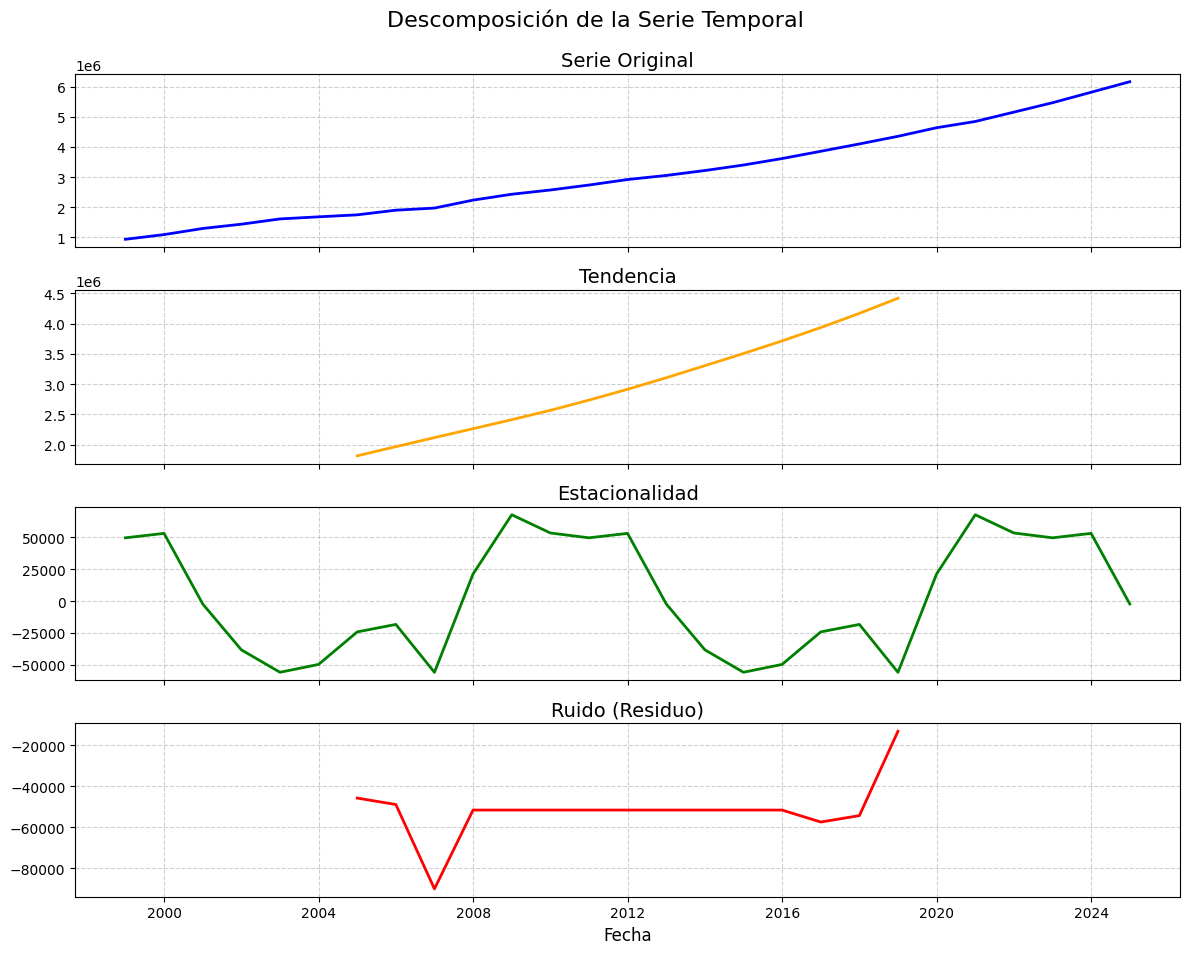

In [55]:
analisis_st.detectar_estacionalidad()

<Figure size 1200x1000 with 0 Axes>

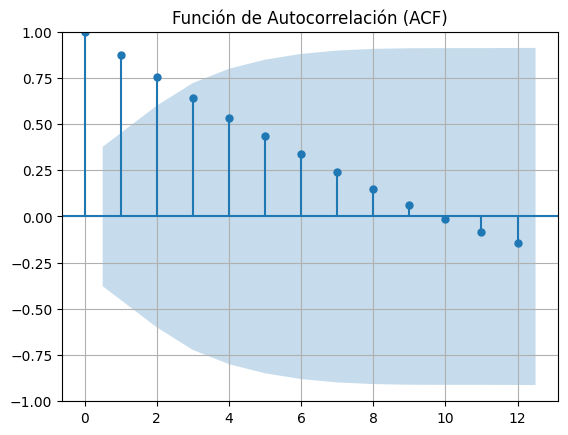

<Figure size 1200x1000 with 0 Axes>

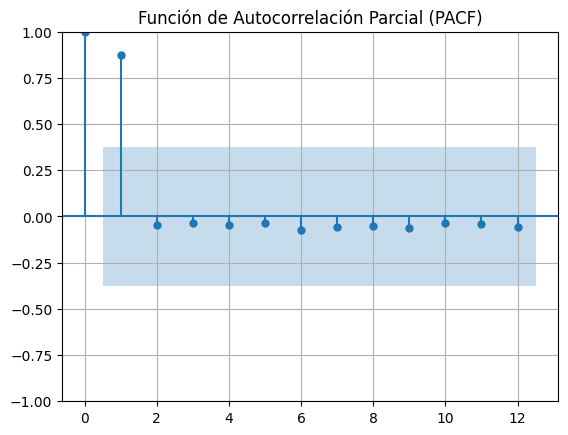

In [56]:
analisis_st.graficar_acf_pacf(lags=12)

## Análisis de las Gráficas ACF y PACF

### **Gráfica ACF (Función de Autocorrelación)**
1. **Lag 1**:
   - La correlación en el primer lag es muy alta (cercana a 0.75), lo que indica que la variable tiene una fuerte relación con su valor del periodo inmediatamente anterior.
   
2. **Lags significativos**:
   - Los lags 2 y 3 tienen correlaciones significativas que sobresalen del intervalo de confianza, lo que sugiere que también tienen impacto en la serie.
   - Después del tercer lag, las correlaciones disminuyen gradualmente y se adentran al intervalo de confianza.

3. **Tendencia a cero**:
   - La autocorrelación disminuye de manera lenta y persistente, lo que podría ser indicativo de no estacionaridad o una estructura autorregresiva en la serie.

4. **Estacionalidad**:
   - No tiene estacionalidad ya que son datos anuales   
---

### **Gráfica PACF (Función de Autocorrelación Parcial)**
1. **Lag 1**:
   - El primer lag muestra una correlación significativa (cercana a 0.75), indicando que el valor actual está altamente influenciado por el valor del periodo inmediatamente anterior.

2. **Lags significativos**:
   - El segundo lag también tiene una fuerte conexión, sin embargo pasado este todos caen dentro del intervalo de confianza. De manera que los lags más lejanos no tienen influencia directa significativa.
---

In [57]:
analisis_st.prueba_estacionariedad()

ADF Statistic: 6.443519495590372
p-value: 1.0
Valores Críticos:
1%: -3.7112123008648155
5%: -2.981246804733728
10%: -2.6300945562130176
No podemos rechazar la hipótesis nula. La serie NO es estacionaria.


In [58]:
modelo_arima = st.ARIMAModel()

parametros_arima = modelo_arima.generar_parametros(p_range=range(1,6), q_range=range(1,6))
parametros_arima[:5]

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]

## Dividir la serie en train-test

In [59]:
train_size= int(0.7 * len(df_autos_historicos))
df_autos_historicos.set_index('FECHA', inplace=True)
df_autos_historicos.index = pd.to_datetime(df_autos_historicos.index)
# df_autos_historicos = df_autos_historicos.asfreq('A')

y_train, y_test = df_autos_historicos[:train_size], df_autos_historicos[train_size:]

In [60]:
resultados_arima = modelo_arima.evaluar_modelos(y_train, y_test, parametros_arima, diferenciacion=1)

100%|██████████| 25/25 [00:05<00:00,  4.63it/s]


In [61]:
resultados_arima.head().sort_values(by='RMSE', ascending=True)

,p,q,RMSE
3,1,4,552963
0,1,1,632687
1,1,2,633129
2,1,3,637013
4,1,5,655055


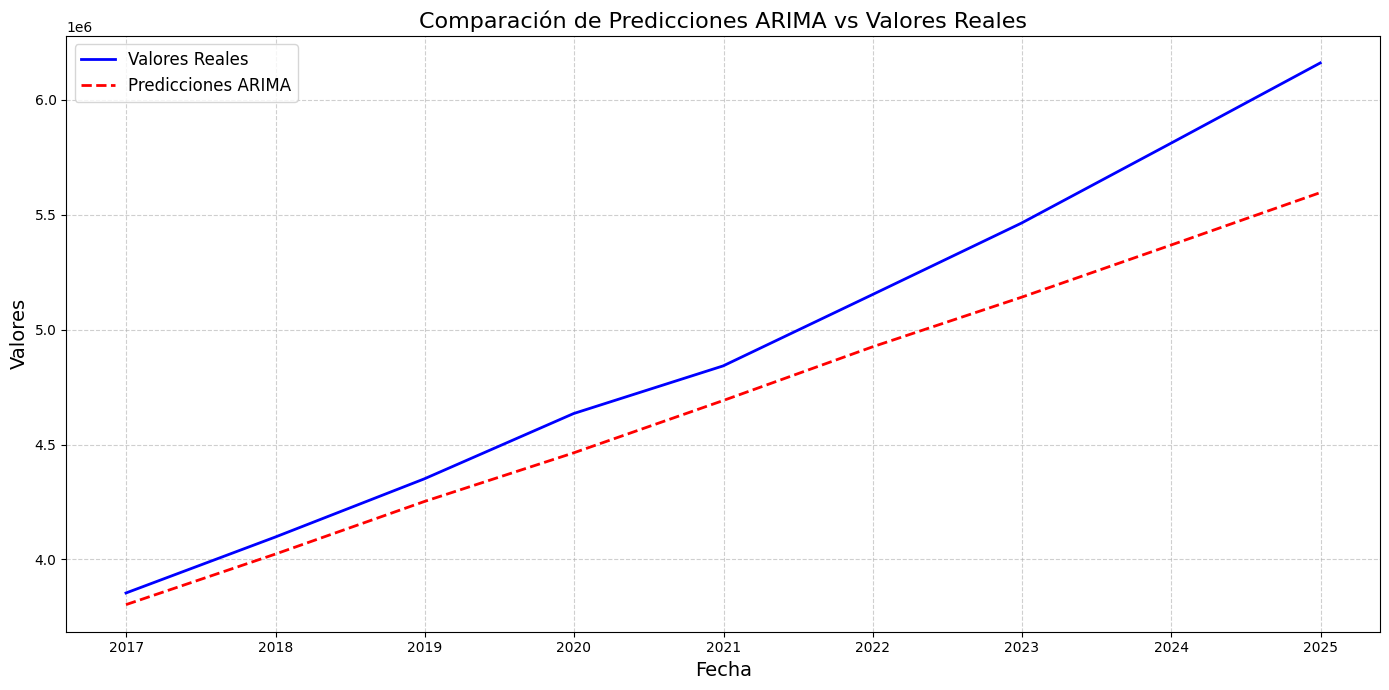

In [62]:
modelo_arima.visualizar_predicciones(y_test)

In [63]:
y_test

,Vehículos
FECHA,
2016-12-31,3854038
2017-12-31,4097338
2018-12-31,4350884
2019-12-31,4634876
2020-12-31,4842367
2021-12-31,5152448
2022-12-31,5463996
2023-12-31,5810888
2024-12-31,6160988


In [106]:
modelo_arima.best_model['pred_test']

FECHA
2016-12-31   3803332
2017-12-31   4023024
2018-12-31   4252227
2019-12-31   4463717
2020-12-31   4691528
2021-12-31   4925008
2022-12-31   5141194
2023-12-31   5367834
2024-12-31   5596613
Name: predicted_mean, dtype: float64

In [66]:
modelo_arima.best_params

{'p': 5, 'q': 3}

## Cálculo de métricas para el y_test

In [ ]:
mae = mean_absolute_error(y_test, modelo_arima.best_model["pred_test"])
mape = mean_absolute_percentage_error(y_test, modelo_arima.best_model["pred_test"])
rmse = np.sqrt(mean_squared_error(y_test, modelo_arima.best_model["pred_test"]))

print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSE: {rmse}")

MAE: 233705.1634665636
MAPE: 4.37%
RMSE: 286864.49275469413


A pesar de que el valor de MAPE es bastante bueno, los valores del MAE y RMSE permanecen altos.

## Conjunto completo

In [115]:
pred_todo = modelo_arima.best_model["modelo"].predict(start=0, end=len(y_test) + len(y_train) - 1)
pred_df = pd.DataFrame({
    "Fecha": pd.concat([y_train, y_test]).index,
    "Valor Real": pd.concat([y_train, y_test])["Vehículos"],
    "Predicción": pred_todo
})
pred_df.head()

,Fecha,Valor Real,Predicción
1998-12-31,1998-12-31,936083,0
1999-12-31,1999-12-31,1090833,936083
2000-12-31,2000-12-31,1294998,1240507
2001-12-31,2001-12-31,1436165,1473332
2002-12-31,2002-12-31,1611023,1592847


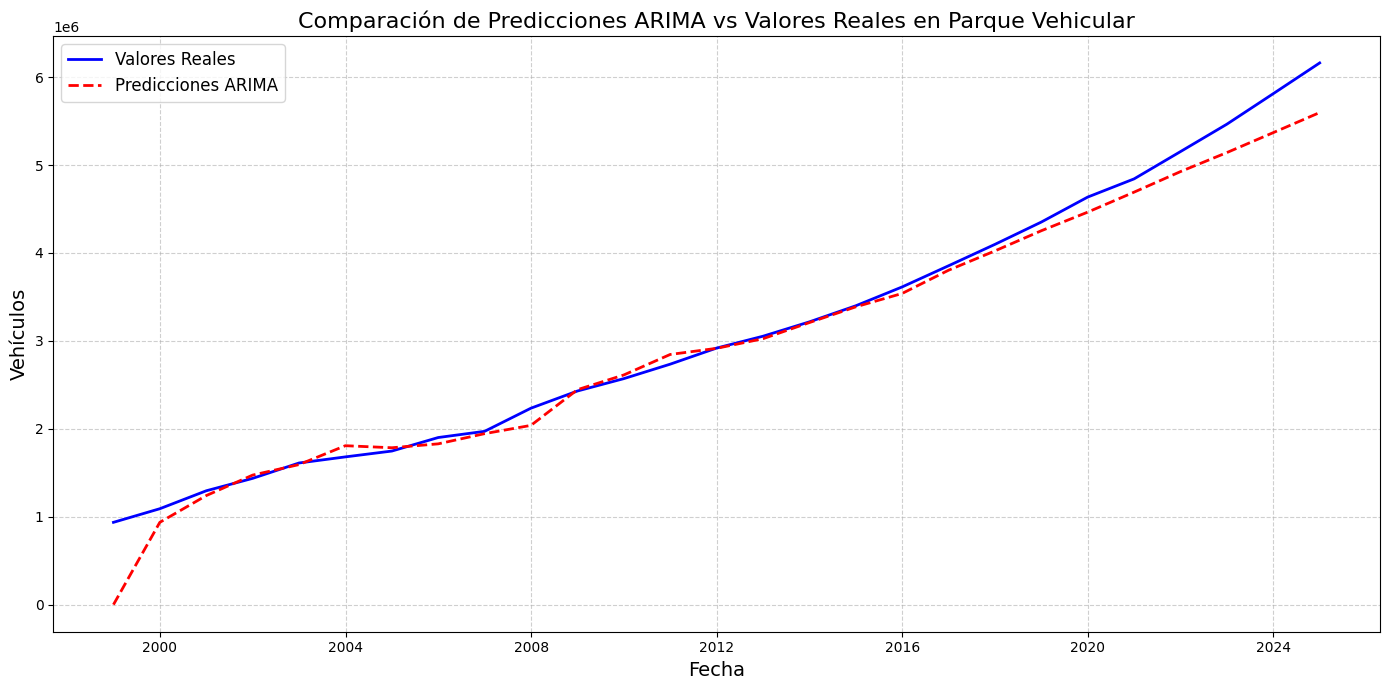

In [110]:
# Configuración de la figura
plt.figure(figsize=(14, 7))

# Graficar valores reales
sns.lineplot(data=pred_df, x="Fecha", y="Valor Real", label="Valores Reales", color="blue", linewidth=2)

# Graficar predicciones
sns.lineplot(data=pred_df, x="Fecha", y="Predicción", label="Predicciones ARIMA", color="red", linestyle="--", linewidth=2)

# Personalización de la gráfica
plt.title("Comparación de Predicciones ARIMA vs Valores Reales en Parque Vehicular", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Vehículos", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [111]:
# Calcular métricas
mae_todo = mean_absolute_error(pred_df["Valor Real"], pred_df["Predicción"])
mape_todo = mean_absolute_percentage_error(pred_df["Valor Real"], pred_df["Predicción"])
rmse_todo = np.sqrt(mean_squared_error(pred_df["Valor Real"], pred_df["Predicción"]))

# Mostrar resultados
print(f"MAE para toda la serie: {mae_todo}")
print(f"MAPE para toda la serie: {mape_todo * 100:.2f}%")
print(f"RMSE para toda la serie: {rmse_todo}")

MAE para toda la serie: 150194.43418760004
MAPE para toda la serie: 7.22%
RMSE para toda la serie: 252972.20236123272


### Métricas del modelo ARIMA
- **MAE (Error Absoluto Medio):** 150,194.43  
  Este valor indica que, en promedio, el modelo SARIMA comete un error absoluto de aproximadamente 150,194 vehículos en sus predicciones.
- **MAPE (Error Porcentual Absoluto Medio):** 7.22%  
  Un error porcentual del 7.22% sugiere que las predicciones del modelo están bastante cerca de los valores reales, considerando el rango de magnitud de los datos.
- **RMSE (Raíz del Error Cuadrático Medio):** 252,972.20  
  Este valor, al penalizar más los errores grandes, es relativamente alto, indicando que el modelo tiene dificultades para predecir valores extremos de manera precisa.

### Aplicar mejores parámetros

In [119]:
# Entrenar el modelo ARIMA con los mejores parámetros en toda la serie histórica
mejores_p = modelo_arima.best_params["p"]
mejores_q = modelo_arima.best_params["q"]
mejor_modelo_arima = ARIMA(
    pd.concat([y_train, y_test]),  # Usar toda la serie
    order=(mejores_p, 1, mejores_q)  # Incluir el parámetro `d=1` o el que hayas usado
).fit()

mejor_modelo_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Vehículos   No. Observations:                   27
Model:                 ARIMA(5, 1, 3)   Log Likelihood                -373.421
Date:                Mon, 20 Jan 2025   AIC                            764.842
Time:                        17:06:08   BIC                            776.165
Sample:                    12-31-1998   HQIC                           768.102
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6607      0.051    -12.990      0.000      -0.760      -0.561
ar.L2          0.9659      0.031     31.475      0.000       0.906       1.026
ar.L3          0.9516      0.055     17.262      0.000       0.844       1.060
ar.L4         -0.1838      0.025     -7.304      0.000      -0.233      -0.135
ar.L5         -0.0730      0.023     -3.225      0.001      -0.117      -0.029
ma.L1          0.7785      0.406      1.918      0.055      -0.017       1.574
ma.L2         -0.7785      0.362     -2.148      0.032      -1.489      -0.068
ma.L3         -0.9920      0.073    -13.526      0.000      -1.136      -0.848
sigma2      7.943e+08   9.47e-10   8.39e+17      0.000    7.94e+08    7.94e+08
===================================================================================
Ljung-Box (L1) (Q):                   8.48   Jarque-Bera (JB):                 1.30
Prob(Q):                              0.00   Prob(JB):                         0.52
Heteroskedasticity (H):               2.26   Skew:                            -0.19
Prob(H) (two-sided):                  0.24   Kurtosis:                         1.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.07e+34. Standard errors may be unstable.
"""

In [117]:
# Predecir los próximos 5 años (por ejemplo)
predicciones_futuras = mejor_modelo_arima.predict(start=len(y_train) + len(y_test), 
                                                  end=len(y_train) + len(y_test) + 2)
print(predicciones_futuras)

2025-12-31   6360817
2026-12-31   6600502
2027-12-31   6770294
Freq: A-DEC, Name: predicted_mean, dtype: float64


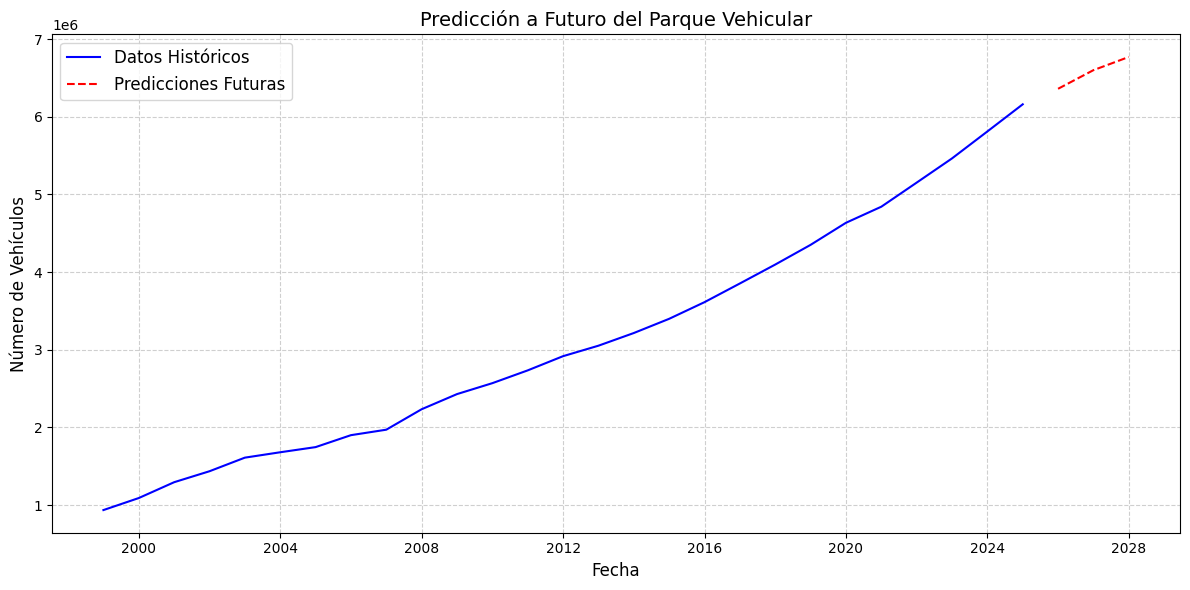

In [118]:
# Crear un rango de fechas para las predicciones futuras
fechas_futuras = pd.date_range(start=y_test.index[-1] + pd.DateOffset(1), periods=len(predicciones_futuras), freq='A')

# Crear un DataFrame para las predicciones futuras
predicciones_df = pd.DataFrame({
    'Fecha': fechas_futuras,
    'Predicción': predicciones_futuras
})

# Unir las predicciones futuras con los datos históricos
datos_historicos_df = pd.concat([y_train, y_test])
datos_historicos_df = pd.DataFrame(datos_historicos_df).reset_index()
datos_historicos_df.columns = ['Fecha', 'Valor Real']

# Graficar los datos
plt.figure(figsize=(12, 6))

# Graficar datos históricos
plt.plot(datos_historicos_df['Fecha'], datos_historicos_df['Valor Real'], label='Datos Históricos', color='blue')

# Graficar predicciones futuras
plt.plot(predicciones_df['Fecha'], predicciones_df['Predicción'], label='Predicciones Futuras', color='red', linestyle='--')

# Personalizar el gráfico
plt.title('Predicción a Futuro del Parque Vehicular', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Vehículos', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


## Prophet

### Métricas del modelo Prophet
- **MAE (Error Absoluto Medio):** 27,953.41  
  En promedio, Prophet tiene un error absoluto significativamente menor que SARIMA, lo que sugiere que sus predicciones son más precisas en términos absolutos.
- **MAPE (Error Porcentual Absoluto Medio):** 1.20%  
  Un MAPE tan bajo indica un excelente ajuste del modelo Prophet, mostrando predicciones altamente precisas en relación con los valores reales.
- **RMSE (Raíz del Error Cuadrático Medio):** 35,695.90  
  Prophet penaliza mucho menos los errores extremos en comparación con SARIMA, lo que refuerza su capacidad de modelado más eficiente.

In [83]:
df_autos_historicos.reset_index(inplace=True)
df_autos_historicos.columns = ['ds', 'y']

In [84]:
df_autos_historicos.head()

,ds,y
0,1998-12-31,936083
1,1999-12-31,1090833
2,2000-12-31,1294998
3,2001-12-31,1436165
4,2002-12-31,1611023


In [85]:
df_autos_historicos.tail()

,ds,y
22,2020-12-31,4842367
23,2021-12-31,5152448
24,2022-12-31,5463996
25,2023-12-31,5810888
26,2024-12-31,6160988


In [86]:
m = Prophet()
m.fit(df_autos_historicos)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=2, freq='Y') 
m.predict(future)

14:58:39 - cmdstanpy - INFO - Chain [1] start processing
14:58:40 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1998-12-31,662029,914509,1003928,662029,662029,297142,297142,297142,297142,297142,297142,0,0,0,959171
1,1999-12-31,811432,1075385,1171200,811432,811432,312234,312234,312234,312234,312234,312234,0,0,0,1123665
2,2000-12-31,961244,1216387,1310868,961244,961244,305977,305977,305977,305977,305977,305977,0,0,0,1267220
3,2001-12-31,1110558,1361825,1448927,1110558,1110558,295056,295056,295056,295056,295056,295056,0,0,0,1405614
4,2002-12-31,1237511,1492704,1579943,1237511,1237511,297142,297142,297142,297142,297142,297142,0,0,0,1534653
5,2003-12-31,1364241,1629615,1720241,1364241,1364241,312234,312234,312234,312234,312234,312234,0,0,0,1676475
6,2004-12-31,1491318,1750313,1843196,1491318,1491318,305977,305977,305977,305977,305977,305977,0,0,0,1797295
7,2005-12-31,1618048,1868843,1959078,1618048,1618048,295056,295056,295056,295056,295056,295056,0,0,0,1913104
8,2006-12-31,1744804,1997755,2087804,1744804,1744804,297142,297142,297142,297142,297142,297142,0,0,0,2041946
9,2007-12-31,1914753,2183621,2270744,1914753,1914753,312234,312234,312234,312234,312234,312234,0,0,0,2226987


In [87]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
24,2022-12-31,5491881,5446128,5536674
25,2023-12-31,5800888,5756734,5849500
26,2024-12-31,6089352,6042506,6135369
27,2025-12-31,6372347,6324867,6421552
28,2026-12-31,6668348,6622407,6719446


In [93]:
df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df['autos'] = df_autos_historicos['y']
df = df[df['autos'].notnull() & df['yhat'].notnull()]
df.tail(5)

,ds,yhat,yhat_lower,yhat_upper,autos
22,2020-12-31,4912885,4865099,4957452,4842367
23,2021-12-31,5195880,5147883,5238254,5152448
24,2022-12-31,5491881,5446128,5536674,5463996
25,2023-12-31,5800888,5756734,5849500,5810888
26,2024-12-31,6089352,6042506,6135369,6160988


In [94]:
# Seleccionar las columnas relevantes
y_real = df['autos']
y_pred = df['yhat']

# Cálculo de MAE
mae = mean_absolute_error(y_real, y_pred)
mape = mean_absolute_percentage_error(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))

# Imprimir los resultados
print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSE: {rmse}")

MAE: 27953.415849852558
MAPE: 1.20%
RMSE: 35695.90172282073


    - Se puede evidenciar un modelo mucho más ajustado, con resultados más reducidos y que de igual forma siguen el patrón de la serie de datos.

In [91]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

## Tendencias

In [92]:
plot_components_plotly(m, forecast)

- En la parte superior, se observa el comportamiento a largo plazo del modelo donde señala una tendencia ascendente. Es decir, el parque vehicular va en aumento.

- En la parte inferior, se muestra la estacionalidad del modelo Esto tendría sentido en caso de tener los valores mensuales. Al no tener estos, se pueden ver dos picos claros: al principio y al final. Esto viene explicado por la tendencia que hemos comentado de aumento a través del tiempo.